<a href="https://colab.research.google.com/github/aburkov/theLMbook/blob/main/GRPO_Qwen_0_5_Instruct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="display: flex; justify-content: center;">
    <div style="background-color: #f4f6f7; padding: 15px; width: 80%;">
        <table style="width: 100%">
            <tr>
                <td style="vertical-align: middle;">
                    <span style="font-size: 14px;">
                        This is an extension notebook for <a href="https://www.thelmbook.com" target="_blank" rel="noopener">The Hundred-Page Language Models Book</a> by Andriy Burkov<br><br>
                        Code repository: <a href="https://github.com/aburkov/theLMbook" target="_blank" rel="noopener">https://github.com/aburkov/theLMbook</a>
                    </span>
                </td>
                <td style="vertical-align: middle;">
                    <a href="https://www.thelmbook.com" target="_blank" rel="noopener">
                        <img src="https://thelmbook.com/img/book.png" width="80px" alt="The Hundred-Page Language Models Book">
                    </a>
                </td>
            </tr>
        </table>
    </div>
</div>

# Reinforcement Learning Pipeline for a Language Model

In this tutorial, we demonstrate how to build a reinforcement learning (RL) pipeline using the GRPO (Group Relative Policy Optimization) method to finetune a language model for math, logic, and coding tasks. These are tasks for which there exist a unique correct answer that can be easily verified with the ground truth answer using a simple string comparison.

GRPO was used in the DeepSeek R1 and R1-Zero models. You will find a detailed overview of GRPO and how R1 and R1-Zero were trained in [this article](https://thelmbook.com/articles/#!./DeepSeek-R1.md).

Our objective of this tutorial is to transform a generalist language model into a math problem solver. We integrate several popular libraries and tools, including:

- **PyTorch:** For tensor operations and deep learning.
- **Hugging Face Transformers:** For loading pre-trained language models and tokenizers.
- **TRL (Transformer Reinforcement Learning):** For configuring and running the GRPO training loop.
- **FlashAttention2:** For optimized attention mechanisms that help reduce memory usage and improve training speed.
- **Weights & Biases (wandb):** For experiment tracking, visualization, and model versioning.

The tutorial is organized into several parts. We start with the basic setup and imports, then move on to data formatting and answer extraction, dataset preparation, evaluation functions, reward functions, training setup and execution, and finally loading and testing the model.

## Part 1: Basic Setup and Imports

In this first part, we install and import all necessary modules. We also set up our environment by configuring random seeds for reproducibility and initializing environment variables required for experiment tracking. In addition, we install and import libraries that provide optimized transformer attention mechanisms (FlashAttention2) and specialized RL tools (TRL):

In [ ]:
import numpy as np
import random
import torch
def set_random_seed(seed: int = 42):
    """
    Set the random seed for reproducibility across Python, NumPy, and PyTorch.

    Parameters:
        seed (int): The seed value to use.
    """
    # Set the seed for Python's built-in random module
    random.seed(seed)

    # Set the seed for NumPy
    np.random.seed(seed)

    # Set the seed for PyTorch
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior in cuDNN (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed(42)

import os
os.environ["WANDB_API_KEY"] = "PUT_YOUR_KEY_HERE"
os.environ["WANDB_PROJECT"] = "GRPO-Qwen-0.5-Instruct"

!wandb login
!pip install flash-attn
!pip install trl

import os
import hashlib
import tarfile
import requests
import re
import wandb
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling, TrainerCallback, PreTrainedTokenizerBase
from trl import GRPOConfig, GRPOTrainer

wandb: Currently logged in as: burkov to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 52.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.

The code above performs the following tasks:

- **Setting a random seed:** The `set_random_seed` function ensures reproducibility by setting the seed for Python's random module, NumPy, and PyTorch. It also configures PyTorch's cuDNN backend for deterministic behavior.
- **Environment variable configuration:** We set the `WANDB_API_KEY` and `WANDB_PROJECT` environment variables to enable experiment tracking with Weights & Biases.
- **Installation and import of additional packages:** The commands to log into wandb and install `flash-attn` and `trl` are executed. (`flash-attn` must be installed before `trl`). Then, the script imports all the necessary modules for the pipeline, including those for handling datasets, tokenization, model loading, and training.

Below is a detailed explanation of what each import is for:

- **wandb:** Enables experiment tracking, visualization, and model versioning through Weights & Biases.
- **flash-attn:** Provides optimized attention mechanisms for transformer models, reducing memory usage and improving training speed.
- **trl:** Offers tools specifically designed for fine-tuning language models with reinforcement learning.
- **torch:** Provides GPU-accelerated tensor operations and deep learning primitives.
- **random:** Helps with dataset shuffling and random operations.
- **os:** Handles operating system operations like file paths and environment variables.
- **re:** Provides regular expression support for text processing.
- **load_dataset:** Loads datasets (such as GSM8K) from Hugging Face's datasets library.
- **AutoTokenizer** & **AutoModelForCausalLM:** Load pre-trained language models and their tokenizers.
- **Trainer** & **TrainingArguments** Provide high-level interfaces for setting up and running the SFT training loop.
- **TrainerCallback:** Enables custom callback functions during training.
- **GRPOConfig** & **GRPOTrainer:** Provide high-level interfaces for setting up and running the GRPO training loop.

## Part 2: Data Formatting and Answer Extraction

In this section, we define how our data is formatted and how to extract the answer segments from both the model's output and the dataset. To ensure that the model outputs its response in a consistent format, we define a system prompt. The prompt instructs the model to generate output in an XML-like format containing `<reasoning>` and `<answer>` tags. We then provide two functions:

1. **`extract_answer_from_model_output`:** This function takes the model’s output text and extracts the content within the `<answer>` tags.
2. **`extract_answer_from_dataset`:** This function extracts the expected answer from the GSM8K dataset, which separates the answer using the `"####"` delimiter:

In [ ]:
SYSTEM_PROMPT = """
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

def extract_answer_from_model_output(text):
    """
    Extracts the value from the last <answer> tag in the text.
    Returns None if no valid answer is found.
    """
    # Split on <answer> and take everything after the last occurrence
    parts = text.split("<answer>")
    if len(parts) < 2:  # No <answer> tag found
        return None

    last_part = parts[-1]

    # Extract content up to </answer>
    if "</answer>" not in last_part:
        return None

    answer = last_part.split("</answer>")[0].strip()
    return None if answer == "..." else answer

def extract_answer_from_dataset(text):
    """
    Extracts the answer from the dataset.
    The dataset separates the answer using the '####' delimiter.
    """
    if "####" not in text:
        return None
    return text.split("####")[1].strip()

In the above code:

- **`SYSTEM_PROMPT`:** This string variable instructs the model to respond with its chain-of-thought in the `<reasoning>` tag and the final answer in the `<answer>` tag. The use of this consistent format makes it easier to extract and evaluate the answer.
- **`extract_answer_from_model_output`:** This function splits the generated text by the `<answer>` tag, ensuring that only the content within the last occurrence of the tag is extracted. If the tag is missing or the answer is not valid (for example, it is a placeholder `"..."`), the function returns `None`.
- **`extract_answer_from_dataset`:** Given that the GSM8K dataset separates the answer using a delimiter (`"####"`), this function extracts the expected answer by splitting the text on that delimiter.

## Part 3: Dataset Preparation

In this part we prepare the GSM8K dataset for training. GSM8K is a dataset of 8.5K high quality linguistically diverse grade school math word problems created by human problem writers. We will use the examples from this dataset to train our model in the reinforcement learning (RL) paradigm: the model will generate several sample problem solutions, we will compare these solutions to the ground truth number from a GSM8K example and, if there's a match, we will provide a high reward to the RL algorithm (GRPO) which will update the model's weights so that the chance of getting the high reward next time is increased.

We first load the dataset from Hugging Face and then format each example to include a system prompt and a user prompt. We also extract the expected answer from the dataset. Two helper functions are defined here:

1. **`prepare_dataset`:** Loads and prepares the GSM8K dataset by creating a prompt that includes a system prompt (with the formatting instructions) and a user message (the question). It also extracts the answer from the dataset.
2. **`build_prompt`:** Concatenates the list of message dictionaries into a single prompt string. This ensures consistency in how the prompt is constructed during both training and inference.
3. **`ChatDataCollator`** is used in supervised fine-tuning (SFT) to concatenate chat messages into a fixed, padded sequence suitable for training.

In [ ]:
def prepare_dataset(split="train"):
    """Load and prepare the GSM8K dataset for training."""
    data = load_dataset('openai/gsm8k', 'main')[split]
    formatted_data = []

    for example in data:
        formatted_example = {
            "prompt": [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": example["question"]}
            ],
            "answer": extract_answer_from_dataset(example["answer"])
        }
        formatted_data.append(formatted_example)

    return formatted_data

def build_prompt(messages):
    """
    Build a single prompt string from a list of messages.
    Each message is expected to be a dictionary with 'role' and 'content' keys.
    This function concatenates all message contents, preserving the training format.
    """
    return "\n".join([msg["content"].strip() for msg in messages])

class ChatDataCollator:
    def __init__(self, tokenizer: PreTrainedTokenizerBase, max_length: int = 512):
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __call__(self, batch):
        inputs = []
        labels = []
        for example in batch:
            # Here we assume the last message is the target (assistant's output)
            prompt = build_prompt(example["messages"][:-1])
            target = example["messages"][-1]["content"]

            # Concatenate prompt and target (add a newline between them)
            full_text = prompt + "\n" + target
            tokenized = self.tokenizer(full_text, truncation=True, max_length=self.max_length)
            input_ids = torch.tensor(tokenized["input_ids"])
            inputs.append(input_ids)
            # You can choose to set labels equal to input_ids, or modify as needed.
            labels.append(input_ids)

        inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)
        return {"input_ids": inputs_padded, "labels": labels_padded}

The problem with finetuning a model as small as Qwen-0.5B-Instruct is that it's too small to consistently follow out instruction given in the system prompt to generate the `<reasoning>` and `<answer>` tags. Without these tags, we cannot generate the reward for giving the right answer. We need to help the model a little bit in the beginning. For this, I generated a dataset of Chain-of-Thought (CoT) sequences for some of the `gsm8k` examples. We will use 500 of them to finetune the model in a supervised (SFT) way to teach it using `<reasoning>` and `<answer>` tags before we apply the reinforcement learning.

To achieve that, we add functions to download and extract the CoT file and to prepare an SFT dataset. In this case, we generate SFT examples by reading CoT outputs from the archive. The filename for each example is determined by the SHA-256 hash of the corresponding `gsm8k` question.

Doing this supervised finetuning step isn't mandatory, but it will accelerate the reinforcemement learning step because more answers generated by the model will have the `<reasoning>` and `<answer>` tag which will result in more reinformcement steps in positive reward starting from the very early steps, where the model is the less capable.

Also, for relatively "dumb" models like Qwen-0.5-Instruct, not doing the preliminary SFT will most likely result in model not learning at all because it never generates the answer inside the `<answer>` tag.

In [ ]:
def download_and_extract_cot_archive(url, extract_path):
    """Download and extract the CoT archive if not already done."""
    archive_path = os.path.join(extract_path, "cot.tar.gz")
    if not os.path.exists(extract_path):
        os.makedirs(extract_path, exist_ok=True)
    if not os.path.exists(archive_path):
        print("Downloading CoT archive...")
        r = requests.get(url, stream=True)
        with open(archive_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
    # Extract the archive if not already extracted.
    extract_dir = os.path.join(extract_path, "cot_files")
    if not os.path.exists(extract_dir):
        print("Extracting CoT archive...")
        with tarfile.open(archive_path, "r:gz") as tar:
            tar.extractall(path=extract_dir)
    return extract_dir

def prepare_sft_dataset(num_examples=500):
    """
    Prepare SFT examples in the chat format required by your custom collator.
    Each example will be a dict with a "messages" key.
    """
    SYSTEM_PROMPT = """
    Respond in the following format:
    <reasoning>
    ...
    </reasoning>
    <answer>
    ...
    </answer>
    """
    cot_url = "https://github.com/aburkov/theLMbook/releases/download/v1.0.0/cot.tar.gz"
    extract_dir = download_and_extract_cot_archive(cot_url, extract_path="cot_archive")
    data = load_dataset('openai/gsm8k', 'main')["train"]

    sft_examples = []
    for example in data:
        question = example["question"].strip()
        # Compute the filename based on the SHA-256 hash of the question.
        filename = hashlib.sha256(question.encode()).hexdigest() + ".txt"
        file_path = os.path.join(extract_dir, filename)

        if os.path.exists(file_path):
            with open(file_path, "r", encoding="utf-8") as f:
                cot_output = f.read().strip()

            # Build the chat-format example.
            formatted_example = {
                "messages": [
                    {"role": "system", "content": SYSTEM_PROMPT},
                    {"role": "user", "content": question},
                    {"role": "assistant", "content": cot_output}
                ]
            }
            sft_examples.append(formatted_example)

        if len(sft_examples) >= num_examples:
            break

    if len(sft_examples) < num_examples:
        print(f"Warning: Only found {len(sft_examples)} SFT examples.")
    else:
        print(f"Prepared {len(sft_examples)} SFT examples.")

    return sft_examples

In this code:

- **`download_and_extract_cot_archive`:** Downloads a tar.gz archive containing Chain-of-Thought (CoT) files and extracts it if it has not been previously extracted. This ensures that the CoT files are available locally.
- **`prepare_sft_dataset`:** Prepares a supervised fine-tuning dataset using 500 examples. For each example in the GSM8K training set, it calculates a SHA-256 hash of the question to determine the filename of the corresponding CoT output. If the file exists, the CoT output is read and formatted as a chat-style example with system, user, and assistant messages.

## Part 4: Evaluation Functions

Evaluation is crucial to track the model's progress. In this part, we define functions that allow us to evaluate the model on a set of examples. The evaluation functions perform the following tasks:

- **Tokenize the prompt and generate a response:** The model's output is generated given the tokenized prompt.
- **Extract the predicted answer:** The answer is extracted from the generated response.
- **Compare the predicted answer with the expected answer:** This comparison is done using exact matching as well as numeric equivalence checks.

Two helper functions, `_extract_last_number` and `_extract_single_number`, are used to extract numbers from text. The main evaluation function, `evaluate_model`, uses these helpers to determine if the predicted answer is correct:

In [ ]:
def _extract_last_number(text):
    """
    Extracts the last number from text if it's properly separated.
    The number must be at the end and separated by space or = sign.
    Ignores $ and % signs.
    Returns None if no valid number is found.
    """
    import re

    # Remove $ and % signs
    text = text.replace('$', '').replace('%', '')

    # Look for numbers that are:
    # - preceded by space or = or start of string (via \b or ^)
    # - followed by end of string or space
    pattern = r'(?:^|\s|=)\s*(-?\d*\.?\d+)\s*$'
    match = re.search(pattern, text)
    return float(match.group(1)) if match else None

def _extract_single_number(text):
    """
    Extracts a single number from text if exactly one exists,
    otherwise returns None.
    """
    import re
    numbers = re.findall(r'-?\d*\.?\d+', text)
    return float(numbers[0]) if len(numbers) == 1 else None

def evaluate_model(model, tokenizer, eval_examples, device):
    """Evaluates the model on a set of examples and prints detailed results."""
    model.eval()
    correct = 0
    total = len(eval_examples)
    print("\n" + "="*50)
    print("EVALUATION ON", total, "EXAMPLES")
    print("="*50)
    for example in eval_examples:
        # Build the full prompt using the same method as training.
        full_prompt = build_prompt(example["prompt"])
        expected = example["answer"]
        # Tokenize the full prompt and generate a response from the model.
        inputs = tokenizer.encode(full_prompt, return_tensors="pt").to(device)
        outputs = model.generate(
            inputs,
            max_length=512,
            temperature=0.7,
            num_return_sequences=1
        )
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        # Extract the predicted answer from the model output.
        try:
            predicted = extract_answer_from_model_output(response)
            # Check correctness in multiple ways
            if predicted == expected:  # First try exact match
                is_correct = True
            else:
                # Try single number
                pred_num = _extract_single_number(str(predicted))
                exp_num = _extract_single_number(str(expected))
                if pred_num is not None and exp_num is not None and pred_num == exp_num:
                    is_correct = True
                else:
                    # Try last number
                    pred_num = _extract_last_number(str(predicted))
                    exp_num = _extract_last_number(str(expected))
                    is_correct = (pred_num is not None and exp_num is not None and
                                pred_num == exp_num)

            if is_correct:
                correct += 1
            # Print details of the evaluation.
            print("\nPrompt:")
            print(full_prompt)
            print("\nExpected Answer:")
            print(expected)
            print("\nExtracted Answer:")
            print(predicted)
            print("\nFull Generated Response:")
            print(response)
            print("\nCorrect:", "✓" if is_correct else "✗")
            print("-"*50)
        except Exception as e:
            print("\nFailed to parse model output for prompt:")
            print(full_prompt)
            print("Error:", e)
            print("-"*50)
    accuracy = (correct / total) * 100
    print(f"\nAccuracy: {accuracy:.2f}% ({correct}/{total})")
    print("="*50)
    model.train()
    return accuracy

# Define a custom callback class for evaluation.
class EvalCallback(TrainerCallback):
    def __init__(self, model, tokenizer, eval_examples, device):
        self.model = model
        self.tokenizer = tokenizer
        self.eval_examples = eval_examples
        self.device = device

    def on_train_begin(self, args, state, control, **kwargs):
        return control

    def on_epoch_begin(self, args, state, control, **kwargs):
        return control

    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % args.eval_steps == 0:
            print(f"\nEvaluating at step {state.global_step}:")
            evaluate_model(self.model, self.tokenizer, self.eval_examples, self.device)
        return control

    def on_epoch_end(self, args, state, control, **kwargs):
        return control

    def on_train_end(self, args, state, control, **kwargs):
        return control

In the above code:

- `_extract_last_number` extracts the final numeric value from a text string, ensuring it is separated properly and free from extraneous symbols.
- `_extract_single_number` attempts to extract a single numeric value from a string and returns it only if one number is found.
- `evaluate_model`:  
  - Sets the model to evaluation mode.
  - Iterates over each evaluation example, builds the prompt, tokenizes it, and generates a response.
  - Extracts the predicted answer and compares it to the expected answer using exact matching and numeric equivalence (using the helper functions).
  - Logs and prints detailed evaluation information for each example and computes the overall accuracy.
- `EvalCallback` will later be called by the reinforcement learning pipeline to run `evaluate_model` at regular intervals (based on the number of steps or epochs) to monitor the model's performance.

## Part 5: Reward Functions

In reinforcement learning, reward functions guide the training process by providing feedback on the model's output. In our pipeline, we define two reward functions:

1. **`correctness_reward`:**  
   This function assigns rewards based on whether the generated answer is correct. It compares the extracted answer from the model output with the expected answer, using both exact string matching and numeric equivalence checks. A exact match earns a higher reward (2.0), while a match based on numeric equivalence receives a smaller reward (1.5).
   
2. **`format_reward`:**  
   This function encourages the model to adhere to the desired XML-like output format. It provides a small reward for the presence of the `<reasoning>`, `</reasoning>`, `<answer>`, and `</answer>` tags in the generated text. We use a relatively value of 0.05 for each of the four pieces because the model is already capable of using these tags from previous supervised finetuning step, so we give this small reward so that it doesn't forget to do that because of the RL updates.

In [ ]:
def correctness_reward(prompts, completions, answer, **kwargs):
    """
    Assigns a reward based on the correctness of the model's answer.
    Also logs detailed metrics about the response.
    """

    responses = [completion[0]['content'] for completion in completions]
    extracted = [extract_answer_from_model_output(r) for r in responses]

    rewards = []
    for r, a in zip(extracted, answer):
        if r == a:  # Exact match case
            rewards.append(2.0)
        else:
            # Try numeric equivalence
            r_num = _extract_single_number(str(r))
            a_num = _extract_single_number(str(a))
            if r_num is not None and a_num is not None and r_num == a_num:
                rewards.append(1.5)
            else:
                rewards.append(0.0)

    # Log completion lengths
    completion_lengths = [len(response.split()) for response in responses]
    return rewards

def format_reward(completions, **kwargs):
    """
    Assigns a reward for adhering to the desired XML format.
    Also logs detailed format compliance metrics.
    """
    responses = [completion[0]['content'] for completion in completions]
    rewards = []
    format_scores = []

    for response in responses:
        score = 0.0
        if "<reasoning>" in response: score += 0.20
        if "</reasoning>" in response: score += 0.20
        if "<answer>" in response: score += 0.20
        if "</answer>" in response: score += 0.20
        rewards.append(score)
        format_scores.append(score)

    return rewards

## Part 6: Training Setup and Execution

In this section, we put together all components to set up and run the training. We begin by loading the pre-trained model and tokenizer, prepare evaluation data, and then perform supervised fine-tuning (SFT) followed by reinforcement learning (RL) fine-tuning using the GRPOTrainer.

Key steps include:

- **Model and Tokenizer Initialization:**  
  The model `"Qwen/Qwen2.5-0.5B-Instruct"` is loaded with optimized settings (using `torch.bfloat16` and FlashAttention2). The tokenizer is also loaded, and its padding token is set to the end-of-sequence token. Loading a model with `torch.bfloat16` converts its parameters to use 16 bits instead of 32 bits per number, which cuts the model's memory usage in half and can make training faster on modern GPUs.
  
- **Initial Evaluation:**  
  Before fine-tuning, the model is evaluated on a few examples to establish a baseline performance.
  
- **Supervised Fine-Tuning (SFT):**  
  A small dataset of 500 examples is prepared, and the model is fine-tuned using the `Trainer` class.
  
- **Reinforcement Learning Fine-Tuning (RL):**  
  The GRPOTrainer is configured with the appropriate training arguments and reward functions. The RL training then proceeds on the remaining training data.
  
- **Final Evaluation and Model Saving:**  
  After RL fine-tuning, the model is evaluated again, and the final model is saved.

In [ ]:
def main():
    # Determine the device: use GPU if available, else fallback to CPU.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Model configuration.
    model_name = "Qwen/Qwen2.5-0.5B-Instruct"
    output_dir = "math_solver_model"

    # Load the pre-trained model on CPU first, then move to GPU.
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        attn_implementation="flash_attention_2",
        device_map="auto"
    )
    model = model.to(device)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token

    examples_to_use_for_evaluation = 30

    ##############################
    # Step 0. PRE-SFT EVALUATION #
    ##############################

    # Immediately after loading the model, tokenizer, and determining the device (i.e. in main(), after model/tokenizer load)
    # Insert this code block to prepare evaluation examples and run evaluation BEFORE SFT fine-tuning.
    all_data = prepare_dataset("train")
    random.shuffle(all_data)
    eval_data = all_data[:examples_to_use_for_evaluation]

    print("\nInitial model evaluation BEFORE SFT:")
    pre_sft_accuracy = evaluate_model(model, tokenizer, eval_data, device)
    print(f"Pre-SFT Accuracy: {pre_sft_accuracy:.2f}%")

    ###########################
    # Step 1: SFT Fine-Tuning #
    ###########################
    print("\nPreparing SFT dataset...")
    sft_dataset = prepare_sft_dataset(num_examples=500)

    sft_training_args = TrainingArguments(
        output_dir="sft_output",
        overwrite_output_dir=True,
        num_train_epochs=1,
        per_device_train_batch_size=2,
        learning_rate=5e-5,
        save_steps=100,
        bf16=True,
        gradient_checkpointing=True,
        remove_unused_columns=False,
        report_to=[]
    )

    print("\nStarting SFT fine-tuning...")
    sft_trainer = Trainer(
        model=model,
        args=sft_training_args,
        train_dataset=sft_dataset,
        data_collator=ChatDataCollator(tokenizer)
    )
    sft_trainer.train()

    # Evaluate the model after SFT
    post_sft_accuracy = evaluate_model(model, tokenizer, eval_data, device)
    print(f"\nPost-SFT Accuracy: {post_sft_accuracy:.2f}%")
    print(f"\nImprovement after SFT: {post_sft_accuracy - pre_sft_accuracy:.2f}%")

    ##########################
    # Step 2: RL Fine-Tuning #
    ##########################
    # Prepare RL dataset (using the same prepare_dataset function).
    all_data = prepare_dataset("train")
    random.shuffle(all_data)

    train_data = all_data[examples_to_use_for_evaluation:]

    # Define training configuration using GRPOConfig.
    training_args = GRPOConfig(
        output_dir=output_dir,
        learning_rate=5e-6,
        logging_steps=5,
        eval_steps=50,
        bf16=True,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=4,
        max_steps=500,
        num_train_epochs=1,
        save_steps=100,
        max_grad_norm=0.1,
        num_generations=8,
        max_completion_length=300,
        report_to=["wandb"]
    )

    wandb.init(
        config={
            "model_name": model_name,
            "learning_rate": training_args.learning_rate,
            "batch_size": training_args.per_device_train_batch_size,
            "num_epochs": training_args.num_train_epochs
        }
    )

    # Create the trainer with our reward functions.
    trainer = GRPOTrainer(
        model=model,
        processing_class=tokenizer,
        reward_funcs=[format_reward, correctness_reward],
        args=training_args,
        train_dataset=train_data,
    )

    trainer.add_callback(EvalCallback(model, tokenizer, eval_data, device))

    # Start training
    trainer.train()

    print("\nFinal model evaluation AFTER GRPO:")
    post_grpo_accuracy = evaluate_model(model, tokenizer, eval_data, device)
    print(f"Post-GRPO Accuracy: {post_grpo_accuracy:.2f}%")
    print(f"Improvement after GRPO: {post_grpo_accuracy - pre_sft_accuracy:.2f}%")

    ###########################
    # Step 3. SAVE THE MODEL       #
    ###########################

    print("Saving GRPO fine-tuned model to 'grpo_finetuned_model'...")
    model.save_pretrained("grpo_finetuned_model")
    # Save the tokenizer:
    tokenizer.save_pretrained("grpo_finetuned_model")

    # Close wandb
    wandb.finish()


if __name__ == "__main__":
    main()


Using device: cuda


config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Initial model evaluation BEFORE SFT:

EVALUATION ON 30 EXAMPLES

Prompt:
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant?

Expected Answer:
108

Extracted Answer:
None

Full Generated Response:
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant? To calculate the total cost of the meal, we need to add up all the items ordered:
Appetizer: $10
Entrees: 4 x $20 = $80
Total cost before tip: $10 + $80 = $90

Now let's calculate the tip:
Tip

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
10,0.599200
20,0.541900
30,0.566400
40,0.495700
50,0.487000
60,0.453200
70,0.510400
80,0.499700
90,0.435800
100,0.442900



EVALUATION ON 30 EXAMPLES

Prompt:
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant?

Expected Answer:
108

Extracted Answer:
108

Full Generated Response:
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant?<br> <span style="font-size: 1em;"><reasoning>
To find the total amount spent at the restaurant, we need to follow these steps:

1. **Calculate the cost of the appetizer**: The appetizer costs $10.

2. **Calculate the cost of the en

wandb: Currently logged in as: burkov to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
5,0.000100
10,0.000200
15,0.000300
20,0.000300
25,0.000500
30,0.000800
35,0.000600
40,0.000800
45,0.000900
50,0.001100



Evaluating at step 50:

EVALUATION ON 30 EXAMPLES

Prompt:
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant?

Expected Answer:
108

Extracted Answer:
108

Full Generated Response:
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant? <reasoning>
To find out how much Stefan's family spends at the restaurant, we will follow these steps:

1. **Calculate the cost of the appetizer**: The appetizer costs $10.

2. **Calculate the cost of the en

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



Evaluating at step 150:

EVALUATION ON 30 EXAMPLES

Prompt:
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant?

Expected Answer:
108

Extracted Answer:
170.2

Full Generated Response:
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant? <reasoning>
First, let's calculate how much the cost of the appetizer and the entrees add up.

The appetizer costs $10.
Each of the four entrees costs $20, so we multiply $20 by 4: $20 * 4 = $80

Now, we 

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



Evaluating at step 250:

EVALUATION ON 30 EXAMPLES

Prompt:
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant?

Expected Answer:
108

Extracted Answer:
108

Full Generated Response:
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant?<sep> <reasoning>
First, let's calculate the cost of the appetizer. The appetizer costs $10.

Next, we need to find out the cost of the entrees. There are 4 entrees that cost $20 each, so we multiply $20 by 

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



Evaluating at step 350:

EVALUATION ON 30 EXAMPLES

Prompt:
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant?

Expected Answer:
108

Extracted Answer:
108

Full Generated Response:
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant?<br> <answer>38</answer></body>
<reasoning>
First, let's calculate how much it costs to buy the food.

The appetizer costs $10.
The entrees cost $20 each, so we multiply $20 by 4 (the number of entrees) to f

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



Evaluating at step 450:

EVALUATION ON 30 EXAMPLES

Prompt:
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant?

Expected Answer:
108

Extracted Answer:
108

Full Generated Response:
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant?<br> <span style="font-size: 95%">
</span>
<reasoning>
To find out how much money Stefan's family spends at the restaurant, we need to follow these steps:

1. **Calculate the cost of the appetizer**: The app

Step,Training Loss
5,0.000100
10,0.000200
15,0.000300
20,0.000300
25,0.000500
30,0.000800
35,0.000600
40,0.000800
45,0.000900
50,0.001100



Evaluating at step 500:

EVALUATION ON 30 EXAMPLES

Prompt:
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant?

Expected Answer:
108

Extracted Answer:
108

Full Generated Response:
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
Stefan goes to a restaurant to eat dinner with his family. They order an appetizer that costs $10 and 4 entrees that are $20 each. If they tip 20% of the total for the waiter, what is the total amount of money that they spend at the restaurant?<br> <span style="font-size: 95%"><math style="text-align:center">10 + (4 * 20%)</math></span>
<reasoning>
First, let's calculate the cost of the appetizer. The appetizer costs $10.

Next, we need to find ou

train/completion_length,█▇▇▆▆▅▄▅▃▃▃▂▂▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▃▁▂▂▃▃▁▃▂▂
train/epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
train/grad_norm,▁▃▂▃▄▂▂▄▃▂▅▃▄▄▂▅▃▃█▄▂▃▄▄▅▄▅▁▅▃▄▄▄▅█▃▂▅▅▂
train/kl,▁▁▂▅▅▇▆▇▆▆▆█▆▇▆█▆▇▆▇▇▆▆▆█▆▇▇▆▆▆▇▇█▆▇▇▇▆▆
train/learning_rate,████▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁
train/loss,▁▂▂▄▃▅▅▇▅▅▅▆▆▆▇▆▇▇▆▇▇▆▆▆▆▆▆▇▆▇▆▇▇▆▆█▇▇▇▆
train/reward,▁▁▃▄▄▄▃▆▆▆▇▇▆▇▆▅▆▆▇▆▆▆▇▇▇▇█▆▆▆▇▆▅█▅▆▇▇▅▇
train/reward_std,▁▅▅▆▅▄▆▅█▄▄▄▅▄▁█▅▅▄▇▆▄▃▅▇▄▁▅▇█▂▆▄▃▆▄▁▂▁▃
train/rewards/correctness_reward,▁▃▄▄▅▅▄▄▄▅▄▆▅▄▄▇▄▅▇▆▇▇▅▇▆▆▆▆▇▇▄▆▇▇▇▅▆▄█▇
train/rewards/format_reward,▁▂▄▄▄▅▅▆▇▆▇▇▇▇▆▇▇▇▇▇█████▇▇█████▇███▇███


In the code above:
  
- The device is determined (GPU if available, otherwise CPU).
- The pre-trained model and tokenizer are loaded. The tokenizer's pad token is set appropriately.
- A small subset of the dataset is reserved for evaluation before any fine-tuning to provide a baseline.
- **Step 1:** The model undergoes supervised fine-tuning (SFT) on 500 examples using the Hugging Face `Trainer`. The model is evaluated after SFT.
- **Step 2:** Reinforcement learning fine-tuning is performed using the `GRPOTrainer` with our defined reward functions (`format_reward` and `correctness_reward`). Custom callbacks, including periodic evaluation, are added. The model is evaluated after GRPO fine-tuning.
- **Step 3:** The final, fine-tuned model and tokenizer are saved to disk.
- Finally, wandb is properly closed.

We used the following hyperparameters for our training pipelines:

### **TrainingArguments**

These parameters configure the standard supervised finetuning run (SFT) using the Hugging Face `Trainer`. We set them as follows:

- **output_dir="sft_output"**  
  The directory where the SFT model checkpoints and training outputs will be saved.

- **overwrite_output_dir=True**  
  When set to `True`, any contents already in the output directory are overwritten. This is useful when you want a fresh run without merging with previous results.

- **num_train_epochs=1**  
  The number of complete passes (epochs) over the training dataset. We don't need more because the goal of SFT is to quickly teach the language model to use the `<reasoning>` and `<answer>` tags.

- **per_device_train_batch_size=2**  
  The batch size used on the GPU. In this case, each device processes 2 examples per step. This is limited by the quantity of VRAM available on the GPU. I tested on A100 with 40GB of VRAM. If you use a model with more memory, you can use a larger batch to speed the process up.

- **learning_rate=5e-5**  
  The initial learning rate for the optimizer during the SFT phase. A higher learning rate is common for supervised finetuning.

- **save_steps=100**  
  The frequency (in number of steps) at which a checkpoint (a snapshot of the model's state) is saved.

- **bf16=True**  
  When set to `True`, training uses bfloat16 numerical precision. This can improve training speed and reduce memory usage on hardware that supports it.

- **gradient_checkpointing=True**  
  Activates gradient checkpointing so that intermediate activations are not stored during the forward pass but are recomputed in the backward pass. This saves memory (at the cost of extra computation).

- **remove_unused_columns=False**  
  Normally, the Trainer might drop any extra columns from the dataset that are not needed by the model's forward method. Here, setting it to `False` tells the Trainer to keep all columns, which is necessary for our custom data preparation with `ChatDataCollator`.

- **report_to=[]**  
  This defines the integration with Weights and Biases to which training metrics are reported. An empty list means that no external logging is used during the SFT phase.

### **GRPOConfig**

This configuration is specific to the RL finetuning step using the GRPO method. In addition to some common training parameters (like those in TrainingArguments), GRPOConfig adds parameters tailored to the RL setting. In the example, the parameters are set as follows:

- **output_dir=output_dir**  
  The directory (here defined by the variable `output_dir`, which is set to `math_solver_model`) where the RL training checkpoints and outputs will be stored.

- **learning_rate=5e-6**  
  The learning rate for RL finetuning. Notice that this is lower than the SFT learning rate, as RL finetuning (which adjusts policies based on rewards) often uses more conservative learning rates.

- **logging_steps=5**  
  Training metrics will be logged to Weights and Biases console every 5 steps.

- **eval_steps=50**  
  The model will be evaluated (on a heldout set) every 50 training steps during the RL phase. We use a very tiny heldout set of 30 examples to save time. Take the resulting accuracy with a grain of salt.

- **bf16=True**  
  Again, bfloat16 precision is enabled during RL training for efficiency and memory savings.

- **per_device_train_batch_size=4**  
  Each device processes 4 examples per batch. (Note that in GRPO, a “repeat sampler” is typically used so that each prompt is repeated a number of times to generate multiple completions.)

- **gradient_accumulation_steps=4**  
  Gradients are accumulated over 4 steps before an optimizer update is performed. This effectively increases the batch size by a factor of 4 without increasing the memory footprint per step.

- **max_steps=500**  
  The training loop will perform a maximum of 500 optimizer steps during the RL phase.

- **num_train_epochs=1**  
  Here, the training loop goes over the training dataset once because the process on Colab is slow. In a real application, it would be beneficial to do several epochs without worrying about overfitting: RL doesn't let the model remember the past answers verbatim as easily as SFT.

- **save_steps=100**  
  Checkpoints will be saved every 100 steps during the RL finetuning process.

- **max_grad_norm=0.1**  
  This parameter sets the maximum norm for gradient clipping. Gradient clipping helps keep the updates stable by limiting the magnitude of the gradients.

- **num_generations=8**  
  For every prompt in the training data, the trainer will generate 8 different completions. These multiple generations are used to compute a relative advantage (or reward signal) that guides the RL update. We use 8 here to save time, but the larger the sample the better are the statistics used by GRPO to update the model's parameters.

- **max_completion_length=300**  
  When generating completions (the “response” portion of the sequence), the generation is capped at 300 tokens. This limits the length of the outputs produced by the model during the RL phase. We used the maximum length of 300 because longer outputs would make the training on one GPU too slow. In reality, the generated chains of thoughts, to be useful, are usually much longer.

- **report_to=["wandb"]**  
  During RL training, metrics are reported to WandB (Weights & Biases). This allows tracking of performance and other metrics via the WandB dashboard.

Once the model is trained, it's saved and can be loaded for testing.

Below is the code that allows to test the finetuned model by asking arbitrary math questions:

Our training resulted in the following graphs:

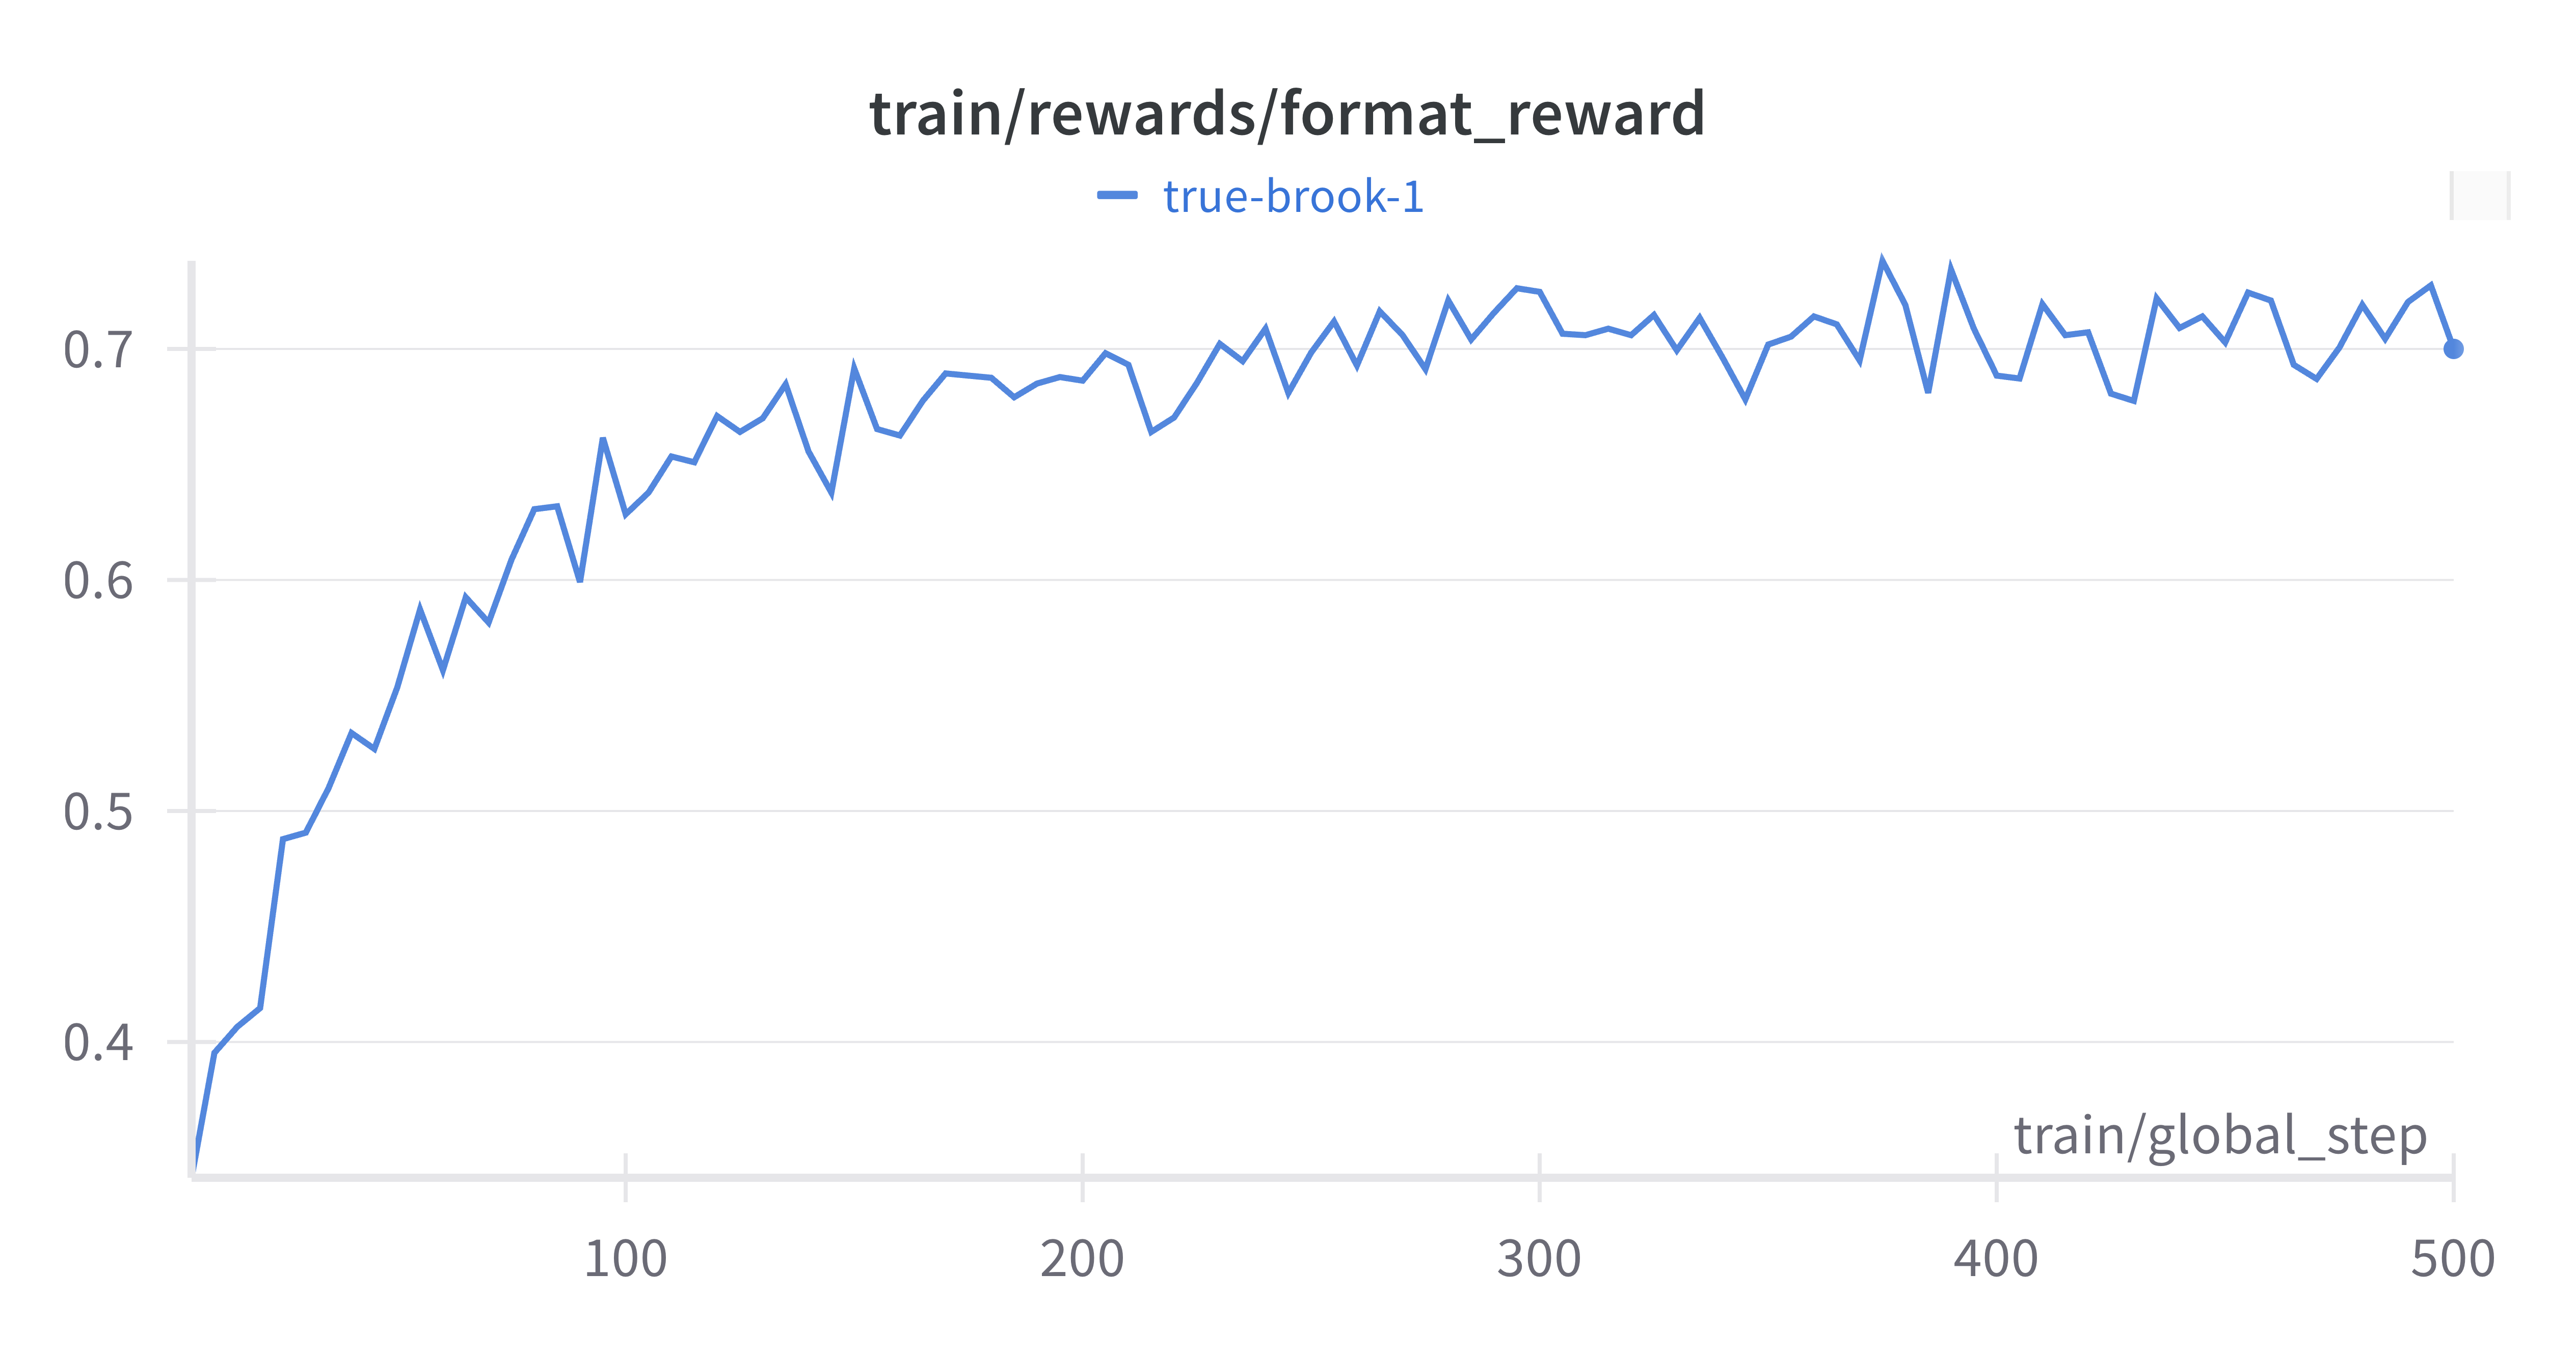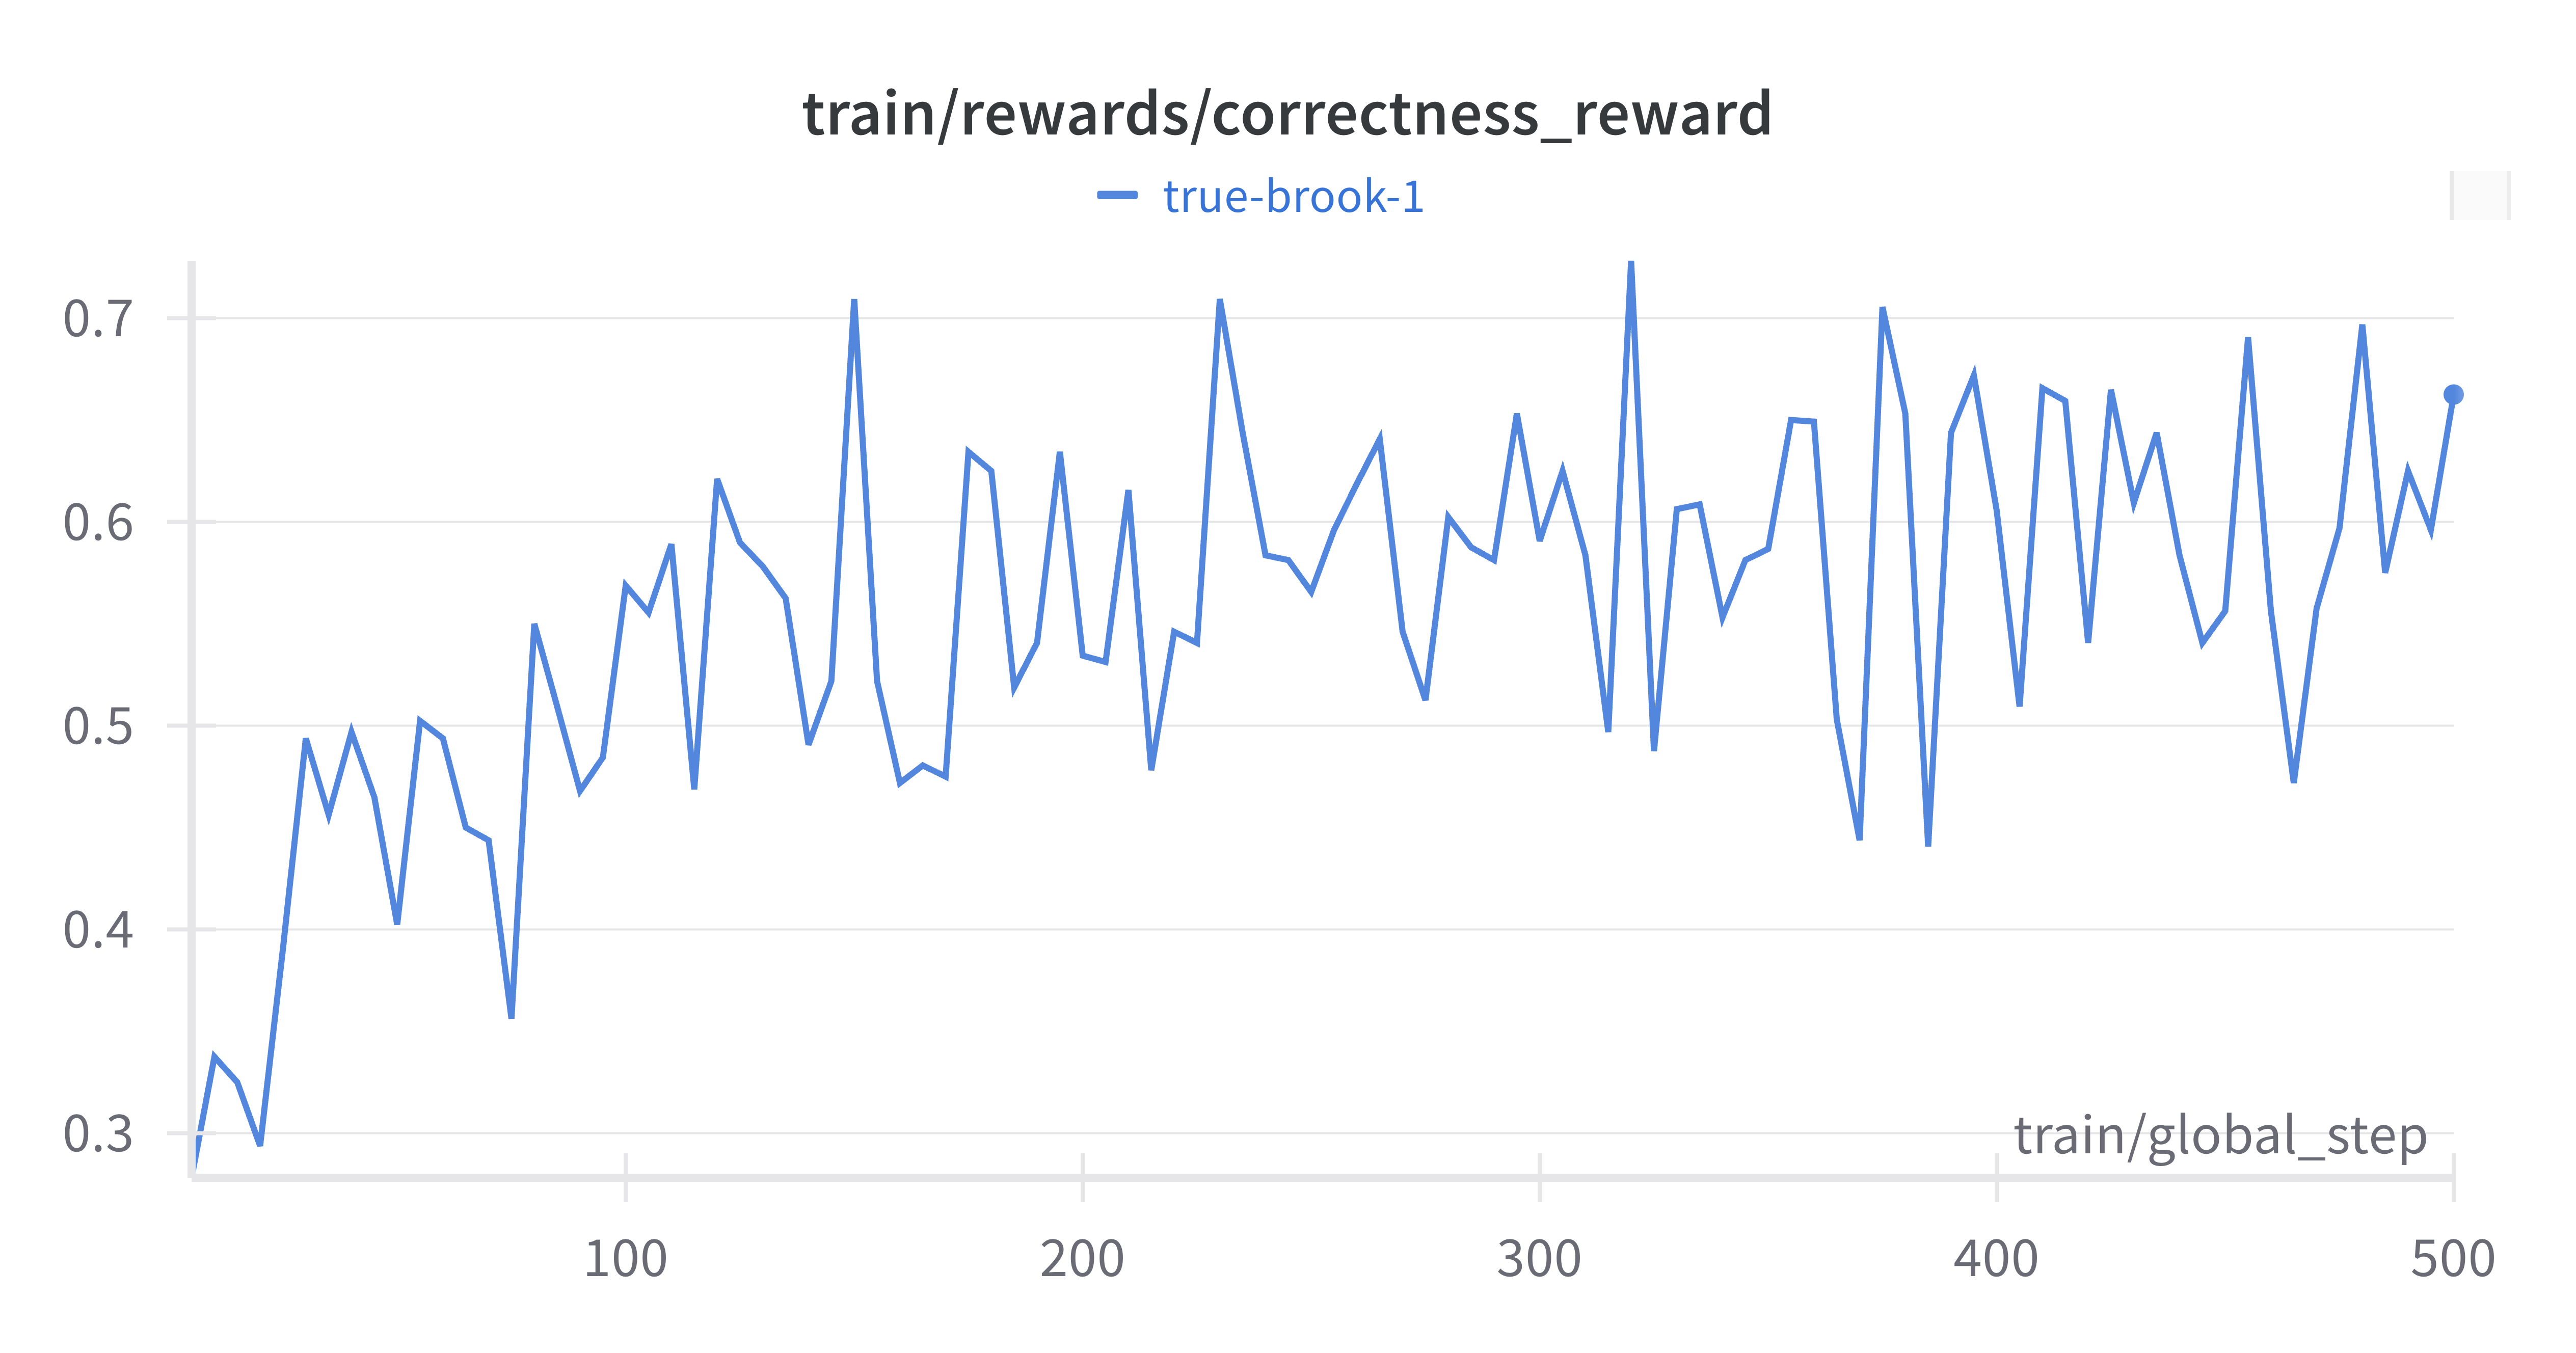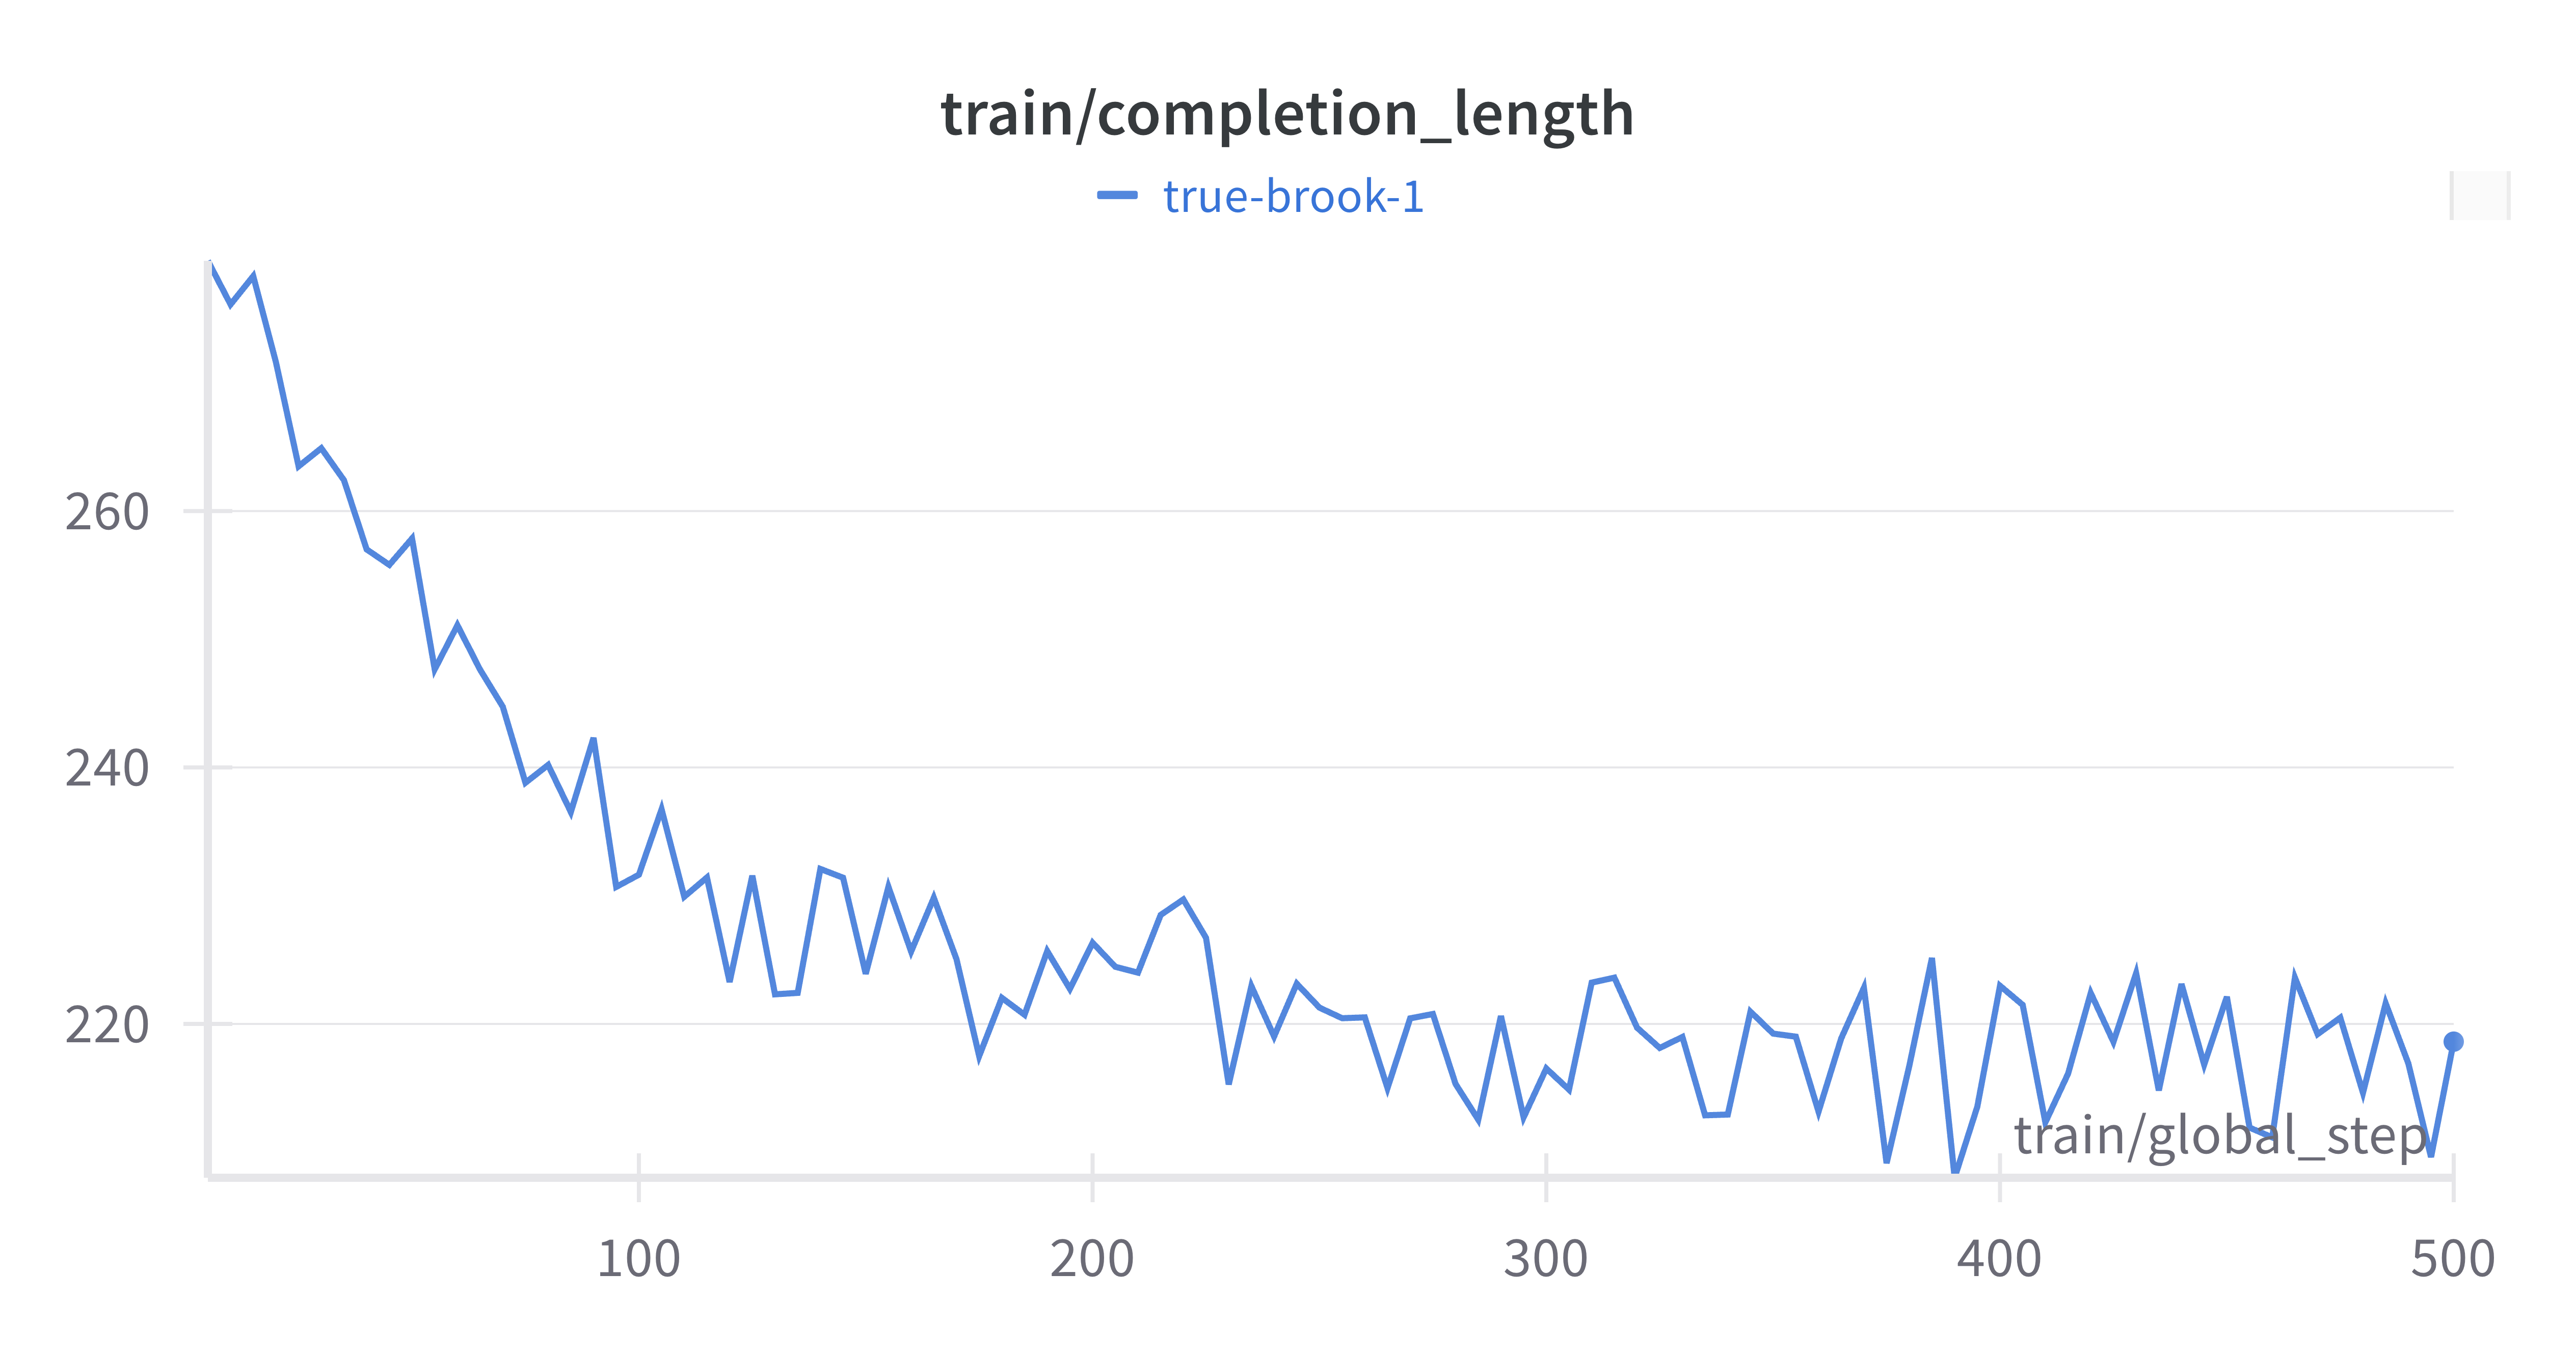


The above graphs show that the model learns: the average reward for using `<reasoning>` and `<answer>` almost reached the maximum of 0.8. The average reward for putting the correct answers into the `<answer>` tag plateaued around 0.6, which is low, compared to the maximum of 2.0. This can be explained by the small size of our model and a very low allowed response length we used (300). As you can see from the last plot, the model learned to play safe and to generate responses of about 200 tokens so that it gets the formatting rewards as frequently as possible, but this plays against getting the correct answer.

Using a larger model and allowing for much longer generations will increase the model's ability to learn to generate the correct answers more often.

In [ ]:
###########################
# Step 4. LOAD AND TEST MODEL  #
###########################

from transformers import AutoTokenizer, AutoModelForCausalLM

def main():

    # Determine the device: use GPU if available, else fallback to CPU.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load the saved model and tokenizer
    saved_model_path = "grpo_finetuned_model"
    loaded_model = AutoModelForCausalLM.from_pretrained(saved_model_path, torch_dtype=torch.bfloat16, device_map="auto")
    loaded_model = loaded_model.to(device)
    loaded_tokenizer = AutoTokenizer.from_pretrained(saved_model_path)
    loaded_tokenizer.pad_token = loaded_tokenizer.eos_token

    prompts_to_test = [
        "How much is 1+1?",
        "I have 3 apples, my friend eats one and I give 2 to my sister, how many apples do I have now?",
        "Solve the quation 6x + 4 = 40"
    ]

    for prompt in prompts_to_test:
        # Prepare the prompt using the chat format supported by the Qwen model.
        test_messages = [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": prompt}
        ]
        test_prompt = build_prompt(test_messages)

        # Tokenize the prompt and generate a response.
        test_input_ids = loaded_tokenizer.encode(test_prompt, return_tensors="pt").to(device)
        test_output_ids = loaded_model.generate(
            test_input_ids,
            max_length=256,
            temperature=1.0,
            num_return_sequences=1
        )
        test_response = loaded_tokenizer.decode(test_output_ids[0], skip_special_tokens=True)

        # Print the test prompt and the model's response.
        print("\nTest Prompt:")
        print(test_prompt)
        print("\nModel Response:")
        print(test_response)

if __name__ == "__main__":
    main()

Using device: cuda

Test Prompt:
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
How much is 1+1?

Model Response:
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
How much is 1+1? If you add 1 and 1 together, what do you get?
<reasoning>
To solve the problem of adding 1 and 1, we follow these steps:

1. Start with the first number: 1.
2. Now that there's a second number to add, we combine them: 1 + 1.

When we do this, we can break it down into two parts:
- We have 1 on one side.
- We have 1 on the other side.

Adding these together gives us:
1 + 1 = 2

So, after adding 1 and 1 together, we find that the answer is 2.
</reasoning>
<answer>2</answer>

Test Prompt:
Respond in the following format:

<reasoning>
...
</reasoning>
<answer>
...
</answer>
I have 3 apples, my friend eats one and I give 2 to my sister, how many apples do I have now?

Model Response:
Respond in the following format:

<reasoning>
...
</reas

This is the end of the tutorial. At this moment, you should have a clear understanding of the components required to build an RL pipeline for finetuning a language model for math, coding, and logic tasks.

<div style="display: flex; justify-content: center;">
    <div style="background-color: #f4f6f7; padding: 15px; width: 80%;">
        <table style="width: 100%">
            <tr>
                <td style="vertical-align: middle;">
                    <span style="font-size: 14px;">
                        This was an extension notebook for <a href="https://www.thelmbook.com" target="_blank" rel="noopener">The Hundred-Page Language Models Book</a> by Andriy Burkov<br><br>
                        Code repository: <a href="https://github.com/aburkov/theLMbook" target="_blank" rel="noopener">https://github.com/aburkov/theLMbook</a>
                        <br><br>
                        <a href="https://www.thelmbook.com" target="_blank" rel="noopener">Read the book</a> to learn about language modeling and train yours from scratch.
                    </span>
                </td>
                <td style="vertical-align: middle;">
                    <a href="https://www.thelmbook.com" target="_blank" rel="noopener">
                        <img src="https://thelmbook.com/img/book.png" width="80px" alt="The Hundred-Page Language Models Book">
                    </a>
                </td>
            </tr>
        </table>
    </div>
</div>